In [1]:
import json 
import numpy as np 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pickle
import colorama 
from colorama import Fore, Style, Back
import random

c:\Users\chris\miniconda3\envs\spyder-env\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
with open('intents.json') as file:
    data = json.load(file)
    
training_sentences = []
training_labels = []
labels = []
responses = []


for intent in data['intents']:
    for pattern in intent['patterns']:
        training_sentences.append(pattern)
        training_labels.append(intent['tag'])
    responses.append(intent['responses'])
    
    if intent['tag'] not in labels:
        labels.append(intent['tag'])
        
num_classes = len(labels)

In [3]:
lbl_encoder = LabelEncoder()
lbl_encoder.fit(training_labels)
training_labels = lbl_encoder.transform(training_labels)

In [4]:
vocab_size = 1000
embedding_dim = 16
max_len = 20
oov_token = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded_sequences = pad_sequences(sequences, truncating='post', maxlen=max_len)

In [5]:
model = keras.Sequential([
keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_len),
#keras.layers.LSTM(units=128),
#keras.layers.GlobalAveragePooling1D(),
keras.layers.GRU(units=16, return_sequences=True),
keras.layers.LSTM(units=128),
keras.layers.Dense(16, activation='relu'),
keras.layers.Dropout(0.3),
keras.layers.Dense(16, activation='relu'),
#keras.layers.Dropout(0.2),
keras.layers.Dense(num_classes, activation='softmax')])

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 16)            16000     
                                                                 
 gru (GRU)                   (None, 20, 16)            1632      
                                                                 
 lstm (LSTM)                 (None, 128)               74240     
                                                                 
 dense (Dense)               (None, 16)                2064      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 80)                1

In [6]:
epochs = 500
history = model.fit(padded_sequences, np.array(training_labels), epochs=epochs, verbose=1, validation_split=0.1)

Epoch 1/500
7/7 [==============================] - 6s 211ms/step - loss: 4.3811 - accuracy: 0.0144 - val_loss: 4.3895 - val_accuracy: 0.0000e+00
Epoch 2/500
7/7 [==============================] - 0s 23ms/step - loss: 4.3725 - accuracy: 0.0192 - val_loss: 4.4095 - val_accuracy: 0.0000e+00
Epoch 3/500
7/7 [==============================] - 0s 22ms/step - loss: 4.3499 - accuracy: 0.0288 - val_loss: 4.5524 - val_accuracy: 0.0000e+00
Epoch 4/500
7/7 [==============================] - 0s 23ms/step - loss: 4.3255 - accuracy: 0.0144 - val_loss: 4.6342 - val_accuracy: 0.0000e+00
Epoch 5/500
7/7 [==============================] - 0s 23ms/step - loss: 4.3180 - accuracy: 0.0240 - val_loss: 4.5525 - val_accuracy: 0.0000e+00
Epoch 6/500
7/7 [==============================] - 0s 23ms/step - loss: 4.2430 - accuracy: 0.0048 - val_loss: 4.9415 - val_accuracy: 0.0000e+00
Epoch 7/500
7/7 [==============================] - 0s 22ms/step - loss: 4.2441 - accuracy: 0.0240 - val_loss: 5.1652 - val_accuracy: 0.

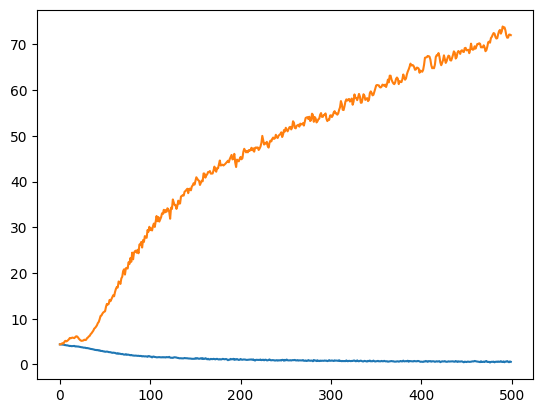

In [7]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [8]:
# to save the trained model
model.save("chat_model")

# to save the fitted tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# to save the fitted label encoder
with open('label_encoder.pickle', 'wb') as ecn_file:
    pickle.dump(lbl_encoder, ecn_file, protocol=pickle.HIGHEST_PROTOCOL)

INFO:tensorflow:Assets written to: chat_model\assets


INFO:tensorflow:Assets written to: chat_model\assets


In [9]:
with open("intents.json") as file:
    data = json.load(file)


def chat():
    # load trained model
    model = keras.models.load_model('chat_model')

    # load tokenizer object
    with open('tokenizer.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)

    # load label encoder object
    with open('label_encoder.pickle', 'rb') as enc:
        lbl_encoder = pickle.load(enc)

    # parameters
    max_len = 20
    
    while True:
        print(Fore.LIGHTBLUE_EX + "User: " + Style.RESET_ALL, end="")
        inp = input()
        if inp.lower() == "quit":
            break

        result = model.predict(keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences([inp]),
                                             truncating='post', maxlen=max_len))
        print(result)                                    
        tag = lbl_encoder.inverse_transform([np.argmax(result)])

        for i in data['intents']:
            if i['tag'] == tag:
                print(Fore.GREEN + "ChatBot:" + Style.RESET_ALL , np.random.choice(i['responses']))

        # print(Fore.GREEN + "ChatBot:" + Style.RESET_ALL,random.choice(responses))

print(Fore.YELLOW + "Start messaging with the bot (type quit to stop)!" + Style.RESET_ALL)
chat()

Start messaging with the bot (type quit to stop)!
1/1 [==============================] - 1s 960ms/step
[[8.58006116e-22 1.23038772e-29 3.48138151e-22 2.66519446e-17
  1.29731018e-02 1.02974917e-09 2.66040373e-03 6.33436888e-02
  8.79792840e-27 1.34419570e-05 2.90924604e-15 1.96497724e-21
  2.98965631e-21 4.01531884e-32 2.59468373e-30 4.31535966e-31
  3.34817692e-30 2.22441162e-29 5.82011828e-33 9.59202920e-31
  1.89338811e-28 1.01036478e-37 7.67192398e-22 0.00000000e+00
  6.27745926e-27 1.53791897e-25 7.92483486e-34 4.32535127e-29
  2.77138693e-38 4.65485718e-36 3.38397590e-30 8.56793770e-27
  8.24857017e-28 1.50180585e-14 9.99174882e-34 3.12382573e-35
  2.90501134e-29 7.94060731e-25 5.73867613e-19 1.64479261e-18
  2.55048863e-19 6.19394897e-25 8.37544746e-24 1.00741257e-04
  9.11786020e-01 5.01938746e-04 1.14761155e-32 4.16384098e-29
  2.74409388e-19 5.48093509e-21 7.78315745e-26 1.27849755e-15
  2.02252054e-25 2.10172678e-12 5.10821718e-14 3.08153729e-20
  7.53155858e-19 8.84683459e-